In [3]:
import numpy as np

In [300]:
pmw = FP(amp = 1, a = 8*units.kpc, b = 0.35, c = 0.2375, normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
ts = np.linspace(0,34,450)
omwa = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwb = Orbit(vxvv=[1,0.25,0.7,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwa.integrate(ts, pmw, method = 'leapfrog')
omwb.integrate(ts, ps, method = 'leapfrog')

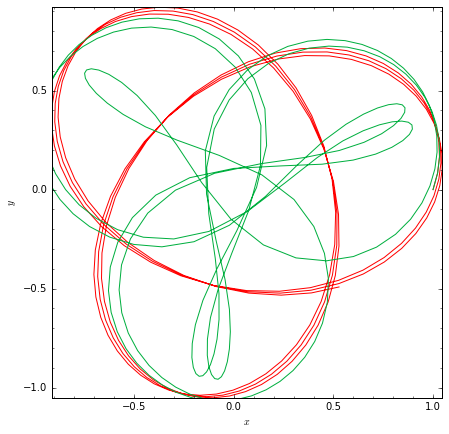

In [150]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.)
omwb.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')
omwa.plot(d1 = 'x', d2 = 'y', overplot = True, color = '#00AF3F')

In [73]:
ts = np.linspace(0,30,250)
omwf = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]
omwg = Orbit(vxvv=[1,0.25,0.6,0,0.0,0]) #[R,vR,vT,z,vz,phi]

omwf.integrate(ts, pmw, method = 'leapfrog')
omwg.integrate(ts, ps, method = 'leapfrog')

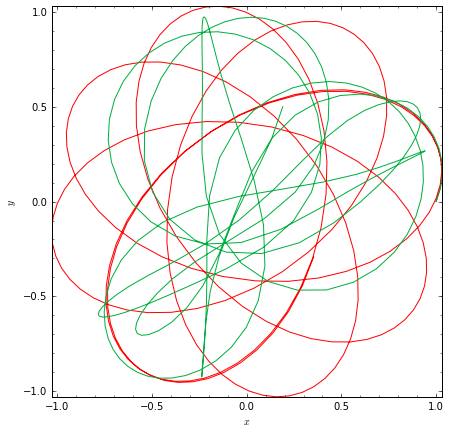

In [74]:
omwg.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')
omwf.plot(d1 = 'x', d2 = 'y', overplot = True, color = '#00AF3F')

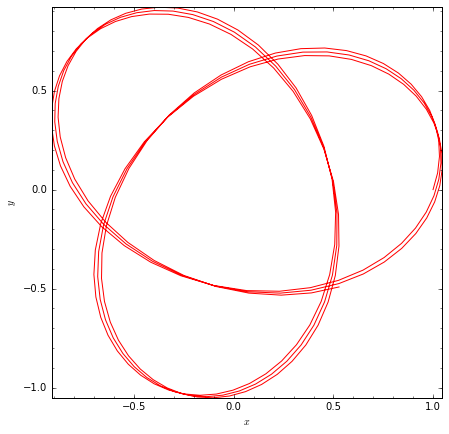

In [67]:
omwc = Orbit(vxvv=[1,0.25,0.7,0,0.0,0])
tsc = np.linspace(0,30,250)
omwc.integrate(tsc, ps, method = 'leapfrog')
omwc.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'red')

[ 1.0001  0.25    0.7     0.      0.      0.    ]


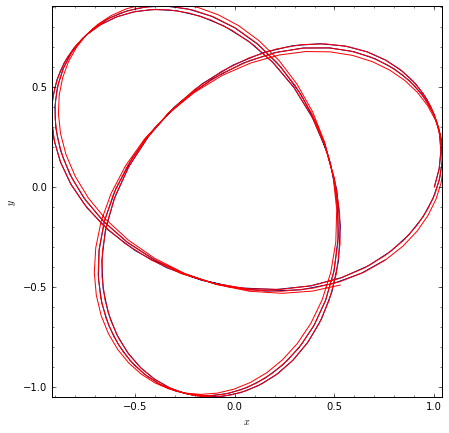

In [302]:
omwc.turn_physical_off()
#t = 10
#icon = np.array([omwc.R(t), omwc.vR(t), omwc.vT(t), omwc.z(t), omwc.vz(t), omwc.phi(t)])
icon = np.array([1.0001,0.25,0.7,0,0.0,0])
print(icon)
omwx = Orbit(vxvv=icon)
tsx = np.linspace(0,20,150)
omwx.integrate(tsx, ps, method = 'leapfrog')
omwx.plot(d1 = 'x', d2 = 'y', overplot = False, color = 'navy')
omwc.plot(d1 = 'x', d2 = 'y', overplot = True, color = 'red')

In [451]:
aaa = np.array([[1,2],[3,4]])
print(aaa[:,1])
print(np.size(aaa))

[2 4]
4


# ==========================  GALI  =============================

In [105]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (7.0, 5.5)

from astropy import units
from galpy.orbit import Orbit
from yyFerrersPotential import FerrersPotential as FP

In [305]:
""" #1
name: vectlist
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    in other than first iteration also 'indev', a list which contains normalized deviation vectors from previous
    iteration to be applied to the current state of the Orbit
    WARNING: Due to the method of creating the deviation vectors none of the coordinates can be zero!
             Otherwise at least two of them are linearly dependent!
output:
    list of initial conditions for deviated orbit; devos
"""
def devolist(icon, indev=None):
    devos = [] 
    if indev == None:
        reldev = 0.0001
        dorb = icon[:]
        #for i in range(len(icon)):
        for i in range(3):
            dorb = icon[:]
            dorb[i] += dorb[i]*reldev
            devos.append(dorb)
    else:
        for i in range(len(indev)):
            dorb = icon[:]
            dorb = list(np.array(devo)+np.array(indev[i]))
            devos.append(devo)
    return devos
# test
#print(vectlist([1,0.25,0.7,0,0.0,0]))#, indev = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,2,1,0,0,0]]))

In [306]:
""" #2
name: evolveorbit
input:
    list of initial conditions for the orbit [R,vR,vT,z,vz,phi]; icon
    final time; tf
    potential; pot
output:
    list of orbit parameters in time tf;
"""
def evolveorbit(icon, tf, pot):
    o = Orbit(vxvv=icon) # [R,vR,vT,z,vz,phi]
    ts = np.linspace(0,tf,10)
    o.integrate(ts, pot, method = 'leapfrog')
    return [o.R(tf),o.vR(tf),o.vT(tf),o.z(tf),o.vz(tf),o.phi(tf)]

In [384]:
""" #3
name: dvector
input:
    evolved orbit o and deviated orbit d
output:
    deviation vector w
"""
def dvector(o,d):
    return np.array(d)-np.array(o)

In [385]:
""" #4
name: matrixnorm
input:
    list of devitation vectors (np.arrays) to be normalized; wj
output:
    np.array of normalized deviation vectors; a
"""
def matrixnorm(wj):
    a = np.array(wj) # creates matrix consisting of k deviation vectors of dimension N
    k = len(a)
    for j in range(k):
        a[j] = abs(a[j] / np.linalg.norm(a[j]))
    return a

# test:        
wj = [[  1.,   1.99969957e-06,   0.,   0.,   0.,   0.],
 [  1.00000008e-06,   1.,   3.87205493e-06,   0.,    0.,   1.26874718e-05],
 [  0.,   6.99879044e-07,   1.,   0.,   0.,   0.]]
a = matrixnorm(wj)

In [386]:
""" #5
name: galivalue
input:
    np.array of deviation vectors; a
output:
    value of gali at a specific time; g
"""
def galivalue(a):
    aT = np.transpose(a)
    s = np.linalg.svd(aT)[1] # creates array of singular values 
    return np.prod(s) # returns product of singular values ~ gali

# test:
galivalue(a)

0.99999999998504896

In [440]:
"""
name: gali
input:
    initial conditions for the orbit
    renormalization time - timestep
    maximum time Tm and small treshold value of the GALI Gm
output:
    current value of gali, new IC for the Orbit, normalized dev. vectors in matrix for next step 
"""
def gali(o, tau, potential, w=None):
    if type(w) == type(None):
        v = devolist(list(o), indev = w) #deviated orbits from the Orbit
    else:
        v = w
    newo = evolveorbit(o, tau, potential) #evolves the Orbit
    wj = []
    for dorbit in v:
        temp = evolveorbit(dorbit, tau, potential) #evolves the deviated orbits to time tau
        wj.append(dvector(o=newo,d=temp)) #creates list of deviation vectors in time tau
    a = matrixnorm(wj) #normalizes the matrix containing deviation vectors in time tau
    return galivalue(a), newo, a #returns value of gali, new IC for the Orbit, normalized dev. vectors in matrix 

ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1,0.25,0.7,0.0,0.0,0.0])
test = gali(icon, 0.000001, ps)
#print(test)

In [480]:
def galievol(o,tau, potential, Tm, Gm):
    galis = np.zeros([1+int(Tm/tau),2]) # array large enough
    #print(len(galis))
    continuing = True # stopping flag
    i = 1 # counter
    w = None #initial setting
    while continuing:
        galis[i-1][1], newo, a = gali(o, tau, potential, w)
        galis[i-1][0] = tau*i
        #if i < 10:
        #    print(Gm, Tm, galis[i-1][1],i*tau)
        if galis[i-1][1]<Gm:
            print('if this code works, the orbit is chaotic...which means it doesn\'t when testing an orbit in axisymmetric potential')
            continuing = False
            return galis[:i-1][:]
        if i*tau > Tm:
            print('time reached treshold, orbit is regular')
            continuing = False
            return galis[:][:]
        i += 1
        o = newo
        w = a

Tm=2.
tau = 10**-2
Gm = 10**-18

ps = FP(amp = 1, a = 8*units.kpc, b = 1., c = 1., normalize = True, omegab = 10.*units.km/units.s/units.kpc)
icon = np.array([1,0.25,0.7,0.0,0.0,0.0])

results = galievol(icon, tau, ps, Tm, Gm)

if this code works, the orbit is chaotic...which means that it doesn't, when testing an orbit in axisymmetric potential


In [465]:
#results[:][:]

array([[  1.00000000e-02,   9.99465375e-01],
       [  2.00000000e-02,   5.62448213e-01],
       [  3.00000000e-02,   2.46335697e-01],
       [  4.00000000e-02,   2.65774556e-01],
       [  5.00000000e-02,   3.14703710e-01],
       [  6.00000000e-02,   3.10126939e-01],
       [  7.00000000e-02,   3.37653142e-01],
       [  8.00000000e-02,   3.27134996e-01],
       [  9.00000000e-02,   3.57521002e-01],
       [  1.00000000e-01,   3.54917535e-01],
       [  1.10000000e-01,   3.49224086e-01],
       [  1.20000000e-01,   3.35528787e-01],
       [  1.30000000e-01,   2.96626343e-01],
       [  1.40000000e-01,   2.96522926e-01],
       [  1.50000000e-01,   2.54409843e-01],
       [  1.60000000e-01,   2.12564950e-01],
       [  1.70000000e-01,   2.22158630e-01],
       [  1.80000000e-01,   1.64794413e-01],
       [  1.90000000e-01,   1.73379269e-01],
       [  2.00000000e-01,   2.13972256e-01],
       [  2.10000000e-01,   1.97051014e-01],
       [  2.20000000e-01,   2.42350837e-01],
       [  

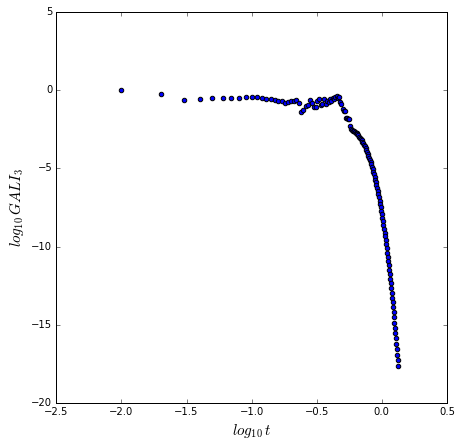

In [470]:
plt.scatter(np.log10(results[:,0]), np.log10(results[:,1]))
plt.xlabel(r'$log_{10}\,t$', fontsize = 15)
plt.ylabel(r'$log_{10}\,GALI_3$', fontsize = 15)

### Behaves like chaotic orbit. Why??